In [ ]:
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold

import sklearn.metrics as metrics
from pandas_ml import ConfusionMatrix

import scikitplot as skplt

%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [3]:
plt.rcParams.update({'font.size': 22})
pd.set_option('display.max_rows', 500)

In [4]:
#Escolas abertas em 2018
abertas2018 =  pd.read_csv('csv/base_abertas2018.csv', sep=','  , engine='python')

In [5]:
#Escolas abertas em 2010 que estavam fechadas em 2018
df =  pd.read_csv('csv/base.csv', sep=','  , engine='python')

In [6]:
#Escolas de MG em 2018
df2018 =  pd.read_csv('csv/Censo_Escolas_MG_2018.csv', sep=','  , engine='python')

In [7]:
#Escolas de MG em 2010 com alguns dados complementares de 2018
df2010 = pd.read_csv('csv/completa2010_sit2018.csv', sep=','  , engine='python')

In [8]:
df2010 = df2010.apply (pd.to_numeric, errors='coerce')
df2010 = df2010.fillna(0)

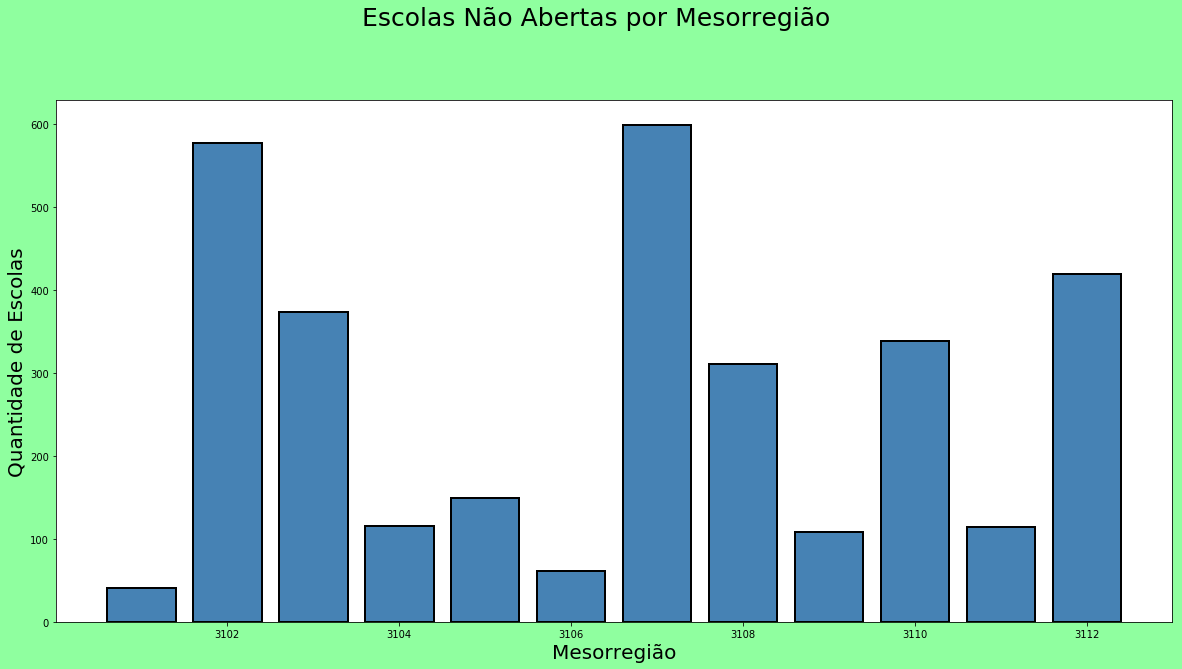

In [7]:
mesorregioes = ['Belo Horizonte','Montes Claros','Teófilo Otoni','Governador Valadares',
                'Ipatinga','Juiz de Fora','Barbacena','Varginha',
                'Pouso Alegre','Uberaba','Uberlândia','Patos de Minas','Divinópolis']
fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Escolas Não Abertas por Mesorregião", fontsize=25)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Mesorregião",fontsize=20)
ax.set_ylabel("Quantidade de Escolas",fontsize=20) 
w_q = df['CO_MESORREGIAO'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
#ax.tick_params(labelsize=14)
bar = ax.bar(w_q[0], w_q[1], color='steelblue', 
        edgecolor='black', linewidth=2)


In [8]:

'''
Belo Horizonte	3101
Montes Claros	3102
Teófilo Otoni	3103
Governador Valadares	3104
Ipatinga	3105
Juiz de Fora	3106
Barbacena	3107
Varginha	3108
Pouso Alegre	3109
Uberaba	3110
Uberlândia	3111
Patos de Minas	3112
Divinópolis	3113
'''

'\nBelo Horizonte\t3101\nMontes Claros\t3102\nTeófilo Otoni\t3103\nGovernador Valadares\t3104\nIpatinga\t3105\nJuiz de Fora\t3106\nBarbacena\t3107\nVarginha\t3108\nPouso Alegre\t3109\nUberaba\t3110\nUberlândia\t3111\nPatos de Minas\t3112\nDivinópolis\t3113\n'

### Correlação entre as demais variáveis e a Situação de Funcionamento da escola

Tratamos apenas de duas opções:
    0. Escola não está em funcionamento (paralisada ou fechada)
    1. Escola em funcionamento

In [10]:
df2010['TP_SITUACAO_FUNCIONAMENTO_y'] = np.where(df2010['TP_SITUACAO_FUNCIONAMENTO_y'] > 1, 0, df2010['TP_SITUACAO_FUNCIONAMENTO_y'])
df2010 = df2010.fillna(value=0)

corr = df2010.corrwith(df2010['TP_SITUACAO_FUNCIONAMENTO_y'], axis = 0).to_frame()#.values.reshape(-1, 1)

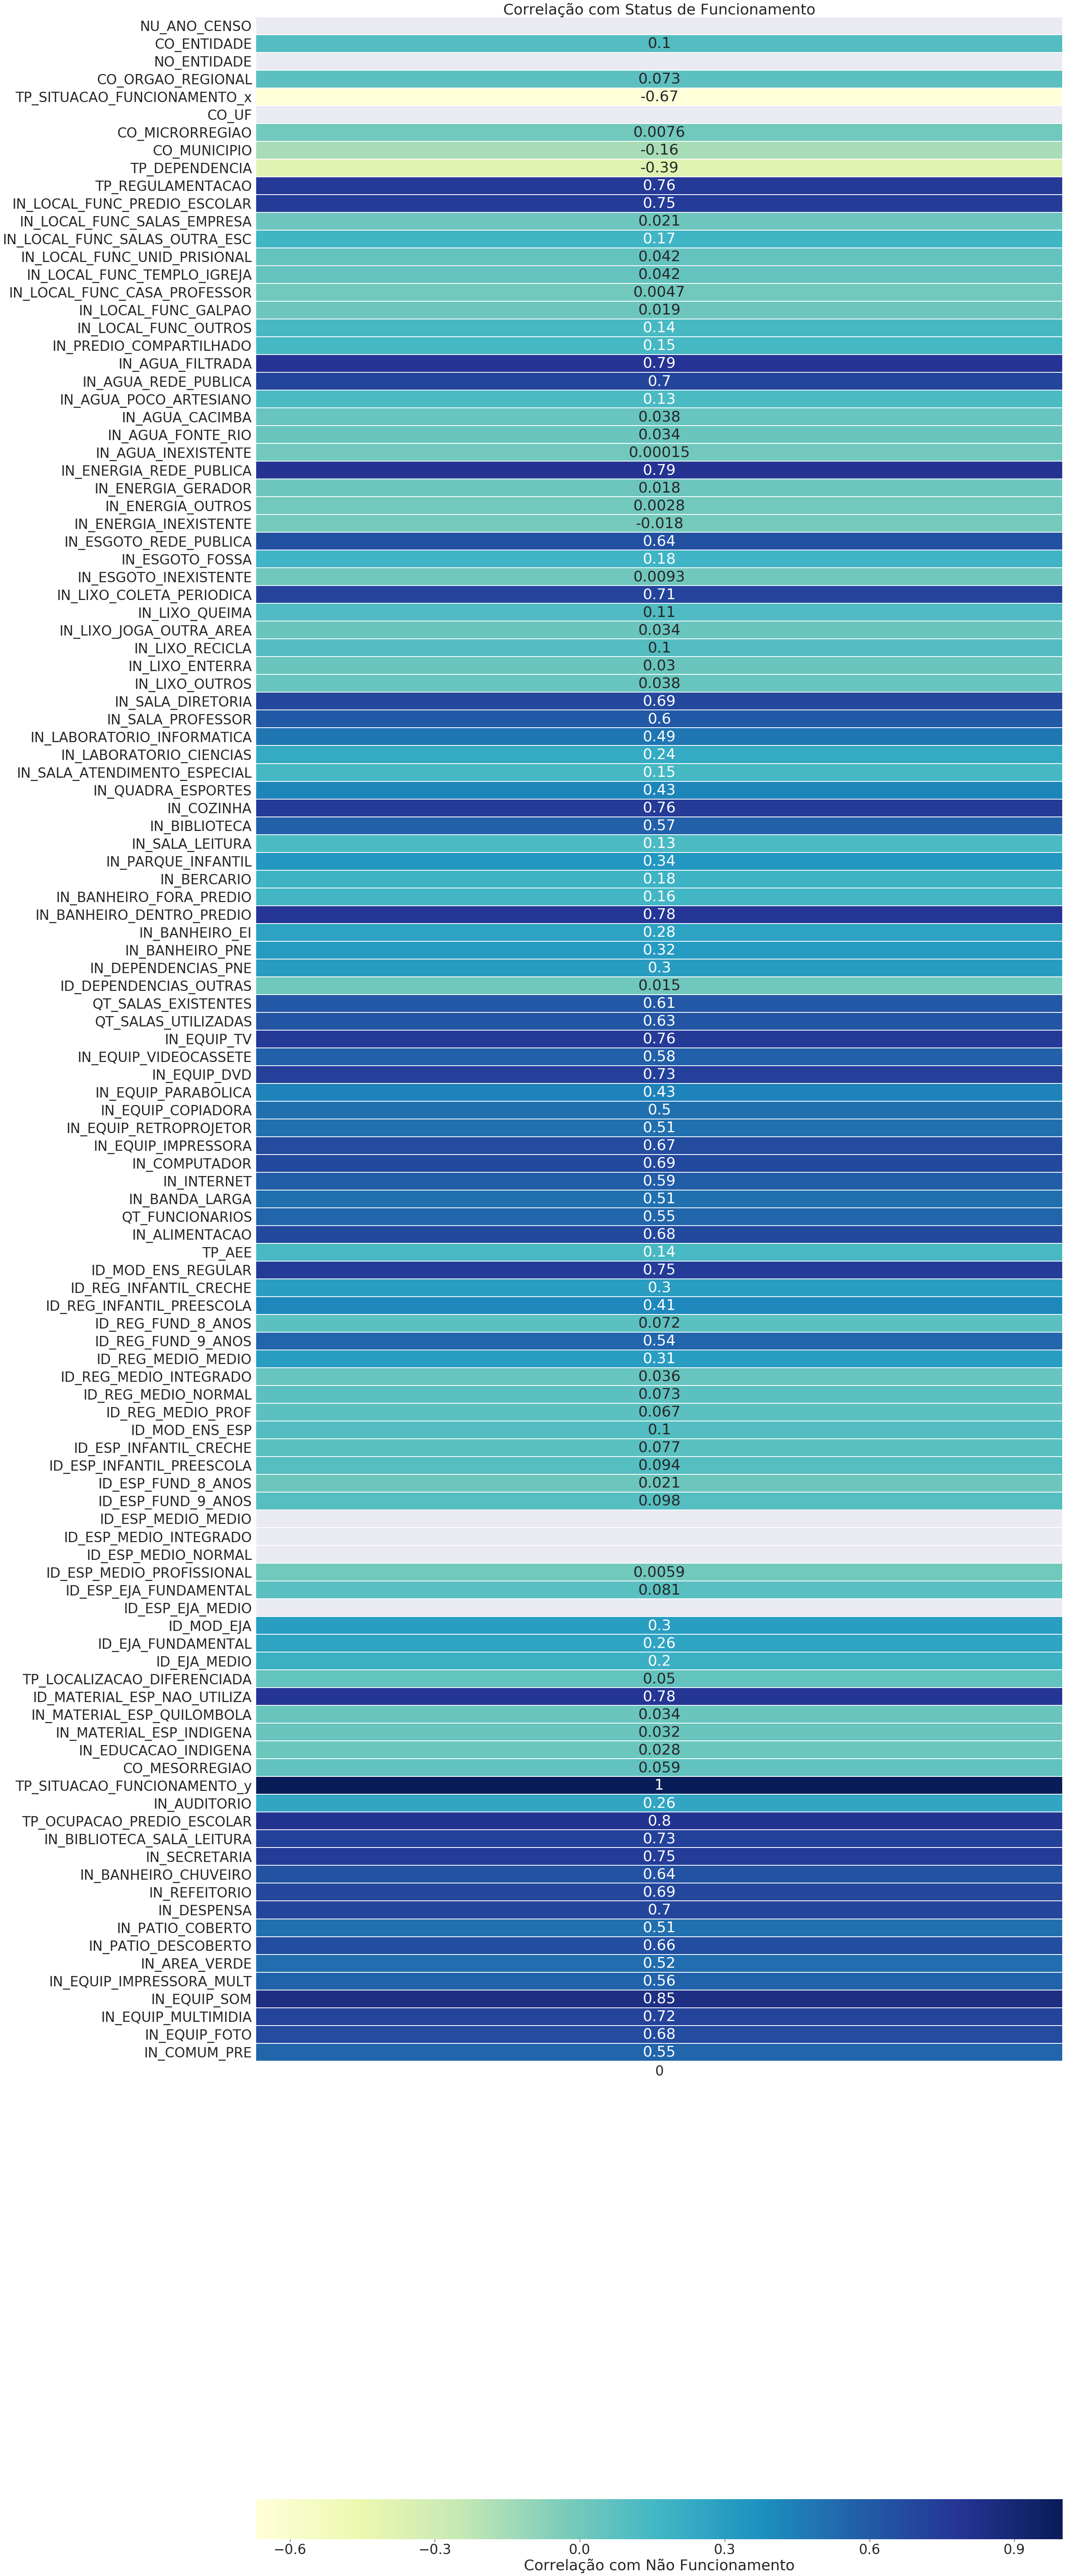

In [57]:
fig = plt.figure(figsize = (35, 130))
sns.set(font_scale=3)
ax = plt.axes()
heat_map = sns.heatmap(corr,cmap="YlGnBu", annot=True, linewidths=1,ax = ax, 
                        cbar_kws={'label': 'Correlação com Não Funcionamento', 'orientation': 'horizontal'
                                 })
ax.set_title('Correlação com Status de Funcionamento')
plt.show()

### Uma métrica para medir o nível de Estrutura de uma Escola
Levando em conta as variáveis com maior correlação com o status de funcionamento da escola. Vamos usar as seguintes váriáveis, todas com peso 1:
    * TP_REGULAMENTACAO 
    * IN_LOCAL_FUNC_PREDIO_ESCOLAR 
    * TP_OCUPACAO_PREDIO_ESCOLAR 
    * IN_AGUA_FILTRADA 
    * IN_AGUA_REDE_PUBLICA 
    * IN_ENERGIA_REDE_PUBLICA 
    * IN_ESGOTO_REDE_PUBLICA 
    * IN_LIXO_COLETA_PERIODICA 
    * IN_SALA_DIRETORIA 
    * IN_SALA_PROFESSOR 
    * IN_LABORATORIO_INFORMATICA 
    * IN_QUADRA_ESPORTES 
    * IN_COZINHA 
    * IN_BIBLIOTECA 
    * IN_BIBLIOTECA_SALA_LEITURA 
    * IN_BANHEIRO_DENTRO_PREDIO 
    * IN_BANHEIRO_PNE 
    * IN_SECRETARIA 
    * IN_BANHEIRO_CHUVEIRO 
    * IN_REFEITORIO 
    * IN_DESPENSA 
    * IN_PATIO_COBERTO 
    * IN_PATIO_DESCOBERTO 
    * IN_AREA_VERDE 
    * IN_EQUIP_TV 
    * IN_EQUIP_DVD 
    * IN_EQUIP_COPIADORA 
    * IN_EQUIP_IMPRESSORA 
    * IN_EQUIP_IMPRESSORA_MULT 
    * IN_EQUIP_SOM 
    * IN_EQUIP_MULTIMIDIA 
    * IN_EQUIP_FOTO 
    * IN_COMPUTADOR 
    * IN_INTERNET 
    * IN_BANDA_LARGA 
    * IN_ALIMENTACAO 
    * IN_COMUM_PRE 

### Diferença no nível de Estrutura entre as escolas abertas e as que fecharam

In [14]:
df = df.apply (pd.to_numeric, errors='coerce')
df = df.fillna(0)

df['infra'] =  (
    df.TP_REGULAMENTACAO +
    df.IN_LOCAL_FUNC_PREDIO_ESCOLAR +
    #df.TP_OCUPACAO_PREDIO_ESCOLAR + só tem dados de 2010 quando não era solicitado
    df.IN_AGUA_FILTRADA +
    df.IN_AGUA_REDE_PUBLICA +
    df.IN_ENERGIA_REDE_PUBLICA +
    df.IN_ESGOTO_REDE_PUBLICA +
    df.IN_LIXO_COLETA_PERIODICA +
    df.IN_SALA_DIRETORIA +
    df.IN_SALA_PROFESSOR +
    df.IN_LABORATORIO_INFORMATICA +
    df.IN_QUADRA_ESPORTES +
    df.IN_COZINHA +
    df.IN_BIBLIOTECA +
    #df.IN_BIBLIOTECA_SALA_LEITURA +
    df.IN_BANHEIRO_DENTRO_PREDIO +
    df.IN_BANHEIRO_PNE +
    #df.IN_SECRETARIA +
    #df.IN_BANHEIRO_CHUVEIRO +
    #df.IN_REFEITORIO +
    #df.IN_DESPENSA +
    #df.IN_PATIO_COBERTO +
    #df.IN_PATIO_DESCOBERTO +
    #df.IN_AREA_VERDE +
    df.IN_EQUIP_TV +
    df.IN_EQUIP_DVD +
    df.IN_EQUIP_COPIADORA +
    df.IN_EQUIP_IMPRESSORA +
    #df.IN_EQUIP_IMPRESSORA_MULT +
    #df.IN_EQUIP_SOM +
    #df.IN_EQUIP_MULTIMIDIA +
    #df.IN_EQUIP_FOTO +
    df.IN_COMPUTADOR +
    df.IN_INTERNET +
    df.IN_BANDA_LARGA +
    df.IN_ALIMENTACAO 
    #df.IN_COMUM_PRE
)

In [15]:
abertas2018 = abertas2018.apply (pd.to_numeric, errors='coerce')
abertas2018 = abertas2018.fillna(0)

abertas2018['infra'] =  (
    abertas2018.TP_REGULAMENTACAO +
    abertas2018.IN_LOCAL_FUNC_PREDIO_ESCOLAR +
    #abertas2018.TP_OCUPACAO_PREDIO_ESCOLAR + só tem dados de 2010 quando não era solicitado
    abertas2018.IN_AGUA_FILTRADA +
    abertas2018.IN_AGUA_REDE_PUBLICA +
    abertas2018.IN_ENERGIA_REDE_PUBLICA +
    abertas2018.IN_ESGOTO_REDE_PUBLICA +
    abertas2018.IN_LIXO_COLETA_PERIODICA +
    abertas2018.IN_SALA_DIRETORIA +
    abertas2018.IN_SALA_PROFESSOR +
    abertas2018.IN_LABORATORIO_INFORMATICA +
    abertas2018.IN_QUADRA_ESPORTES +
    abertas2018.IN_COZINHA +
    abertas2018.IN_BIBLIOTECA +
    #abertas2018.IN_BIBLIOTECA_SALA_LEITURA +
    abertas2018.IN_BANHEIRO_DENTRO_PREDIO +
    abertas2018.IN_BANHEIRO_PNE +
    #abertas2018.IN_SECRETARIA +
    #abertas2018.IN_BANHEIRO_CHUVEIRO +
    #abertas2018.IN_REFEITORIO +
    #abertas2018.IN_DESPENSA +
    #abertas2018.IN_PATIO_COBERTO +
    #abertas2018.IN_PATIO_DESCOBERTO +
    #abertas2018.IN_AREA_VERDE +
    abertas2018.IN_EQUIP_TV +
    abertas2018.IN_EQUIP_DVD +
    abertas2018.IN_EQUIP_COPIADORA +
    abertas2018.IN_EQUIP_IMPRESSORA +
    #abertas2018.IN_EQUIP_IMPRESSORA_MULT +
    #abertas2018.IN_EQUIP_SOM +
    #abertas2018.IN_EQUIP_MULTIMIDIA +
    #abertas2018.IN_EQUIP_FOTO +
    abertas2018.IN_COMPUTADOR +
    abertas2018.IN_INTERNET +
    abertas2018.IN_BANDA_LARGA +
    abertas2018.IN_ALIMENTACAO 
    #abertas2018.IN_COMUM_PRE
)

In [16]:
df2010['infra'] =  (
    df2010.TP_REGULAMENTACAO +
    df2010.IN_LOCAL_FUNC_PREDIO_ESCOLAR +
    df2010.TP_OCUPACAO_PREDIO_ESCOLAR +
    df2010.IN_AGUA_FILTRADA +
    df2010.IN_AGUA_REDE_PUBLICA +
    df2010.IN_ENERGIA_REDE_PUBLICA +
    df2010.IN_ESGOTO_REDE_PUBLICA +
    df2010.IN_LIXO_COLETA_PERIODICA +
    df2010.IN_SALA_DIRETORIA +
    df2010.IN_SALA_PROFESSOR +
    df2010.IN_LABORATORIO_INFORMATICA +
    df2010.IN_QUADRA_ESPORTES +
    df2010.IN_COZINHA +
    df2010.IN_BIBLIOTECA +
    df2010.IN_BIBLIOTECA_SALA_LEITURA +
    df2010.IN_BANHEIRO_DENTRO_PREDIO +
    df2010.IN_BANHEIRO_PNE +
    df2010.IN_SECRETARIA +
    df2010.IN_BANHEIRO_CHUVEIRO +
    df2010.IN_REFEITORIO +
    df2010.IN_DESPENSA +
    df2010.IN_PATIO_COBERTO +
    df2010.IN_PATIO_DESCOBERTO +
    df2010.IN_AREA_VERDE +
    df2010.IN_EQUIP_TV +
    df2010.IN_EQUIP_DVD +
    df2010.IN_EQUIP_COPIADORA +
    df2010.IN_EQUIP_IMPRESSORA +
    df2010.IN_EQUIP_IMPRESSORA_MULT +
    df2010.IN_EQUIP_SOM +
    df2010.IN_EQUIP_MULTIMIDIA +
    df2010.IN_EQUIP_FOTO +
    df2010.IN_COMPUTADOR +
    df2010.IN_INTERNET +
    df2010.IN_BANDA_LARGA +
    df2010.IN_ALIMENTACAO +
    df2010.IN_COMUM_PRE 
    
    )

In [17]:
df2018['infra'] =  (
    df2018.TP_REGULAMENTACAO +
    df2018.IN_LOCAL_FUNC_PREDIO_ESCOLAR +
    df2018.TP_OCUPACAO_PREDIO_ESCOLAR +
    df2018.IN_AGUA_FILTRADA +
    df2018.IN_AGUA_REDE_PUBLICA +
    df2018.IN_ENERGIA_REDE_PUBLICA +
    df2018.IN_ESGOTO_REDE_PUBLICA +
    df2018.IN_LIXO_COLETA_PERIODICA +
    df2018.IN_SALA_DIRETORIA +
    df2018.IN_SALA_PROFESSOR +
    df2018.IN_LABORATORIO_INFORMATICA +
    df2018.IN_QUADRA_ESPORTES +
    df2018.IN_COZINHA +
    df2018.IN_BIBLIOTECA +
    df2018.IN_BIBLIOTECA_SALA_LEITURA +
    df2018.IN_BANHEIRO_DENTRO_PREDIO +
    df2018.IN_BANHEIRO_PNE +
    df2018.IN_SECRETARIA +
    df2018.IN_BANHEIRO_CHUVEIRO +
    df2018.IN_REFEITORIO +
    df2018.IN_DESPENSA +
    df2018.IN_PATIO_COBERTO +
    df2018.IN_PATIO_DESCOBERTO +
    df2018.IN_AREA_VERDE +
    df2018.IN_EQUIP_TV +
    df2018.IN_EQUIP_DVD +
    df2018.IN_EQUIP_COPIADORA +
    df2018.IN_EQUIP_IMPRESSORA +
    df2018.IN_EQUIP_IMPRESSORA_MULT +
    df2018.IN_EQUIP_SOM +
    df2018.IN_EQUIP_MULTIMIDIA +
    df2018.IN_EQUIP_FOTO +
    df2018.IN_COMPUTADOR +
    df2018.IN_INTERNET +
    df2018.IN_BANDA_LARGA +
    df2018.IN_ALIMENTACAO +
    df2018.IN_COMUM_PRE 
    
)

Text(0, 0.5, 'Quantidade de Escolas')

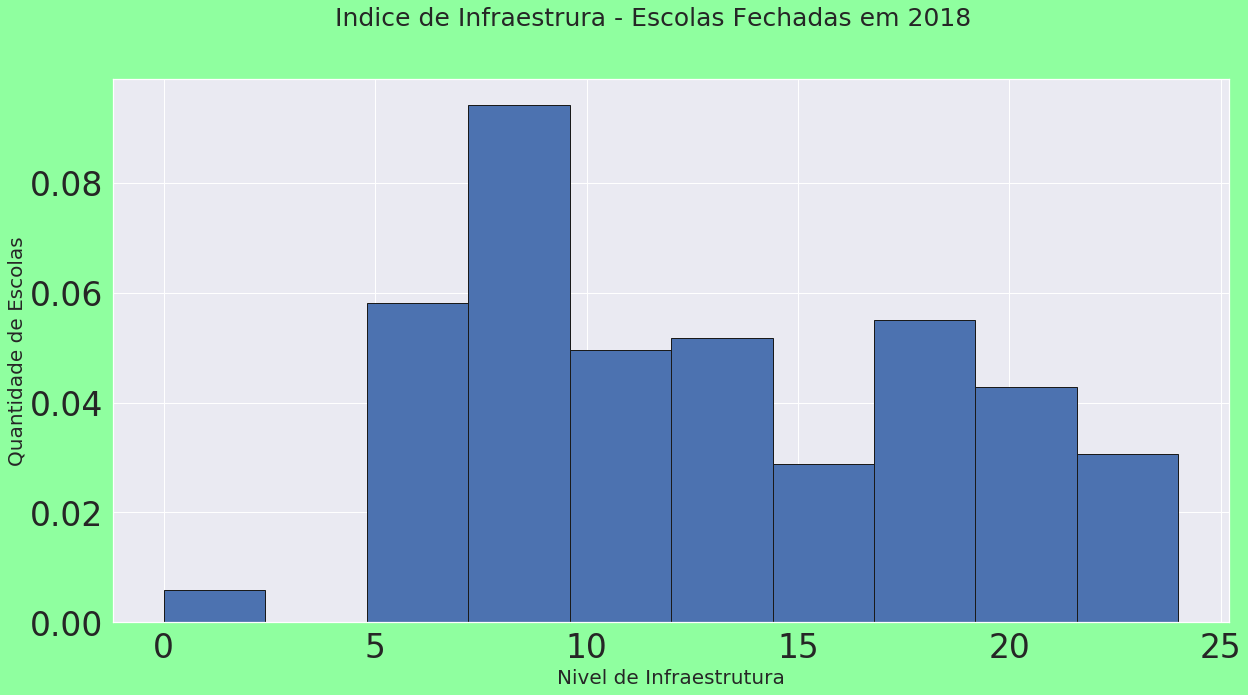

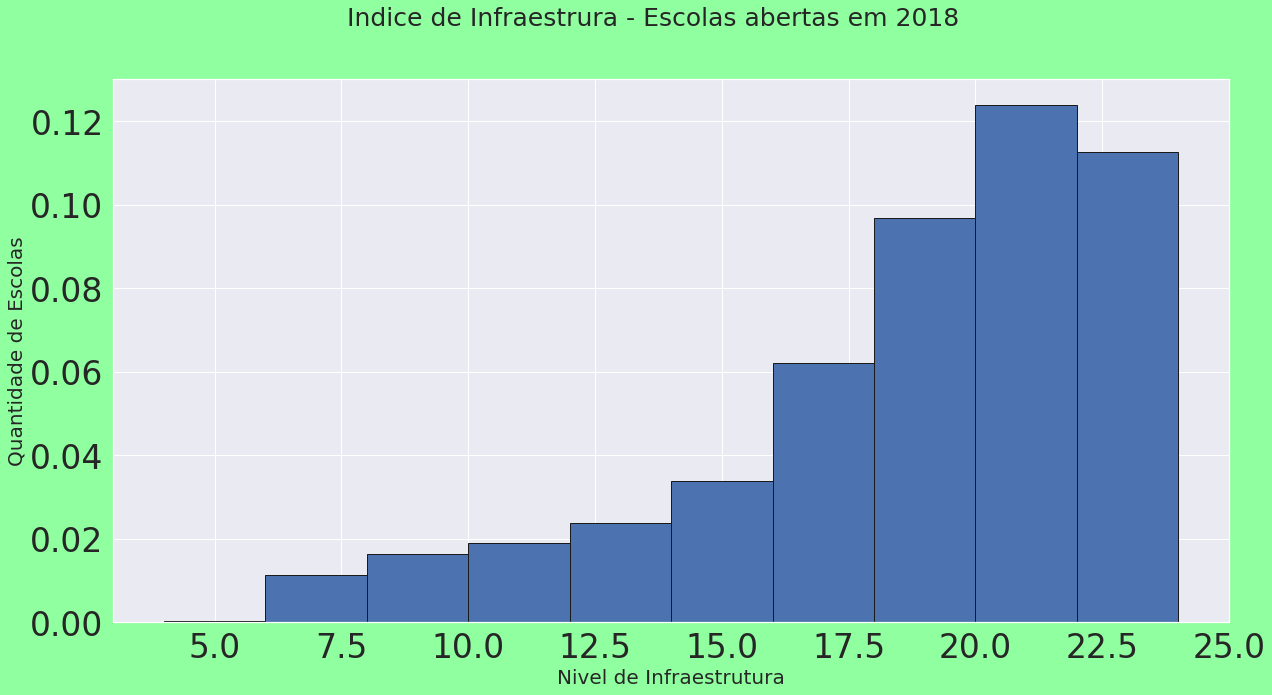

In [18]:
fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Indice de Infraestrura - Escolas Fechadas em 2018", fontsize=25)
plt.hist(df['infra'], density=True, edgecolor='k')
plt.xlabel('Nivel de Infraestrutura', fontsize=20)
plt.ylabel('Quantidade de Escolas', fontsize=20)

fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Indice de Infraestrura - Escolas abertas em 2018", fontsize=25)
plt.hist(abertas2018['infra'], density=True, edgecolor='k')
plt.xlabel('Nivel de Infraestrutura', fontsize=20)
plt.ylabel('Quantidade de Escolas', fontsize=20)

In [19]:
#testando possiveis correlaçoes
'''fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Indice de Infraestrura - Escolas abertas em 2018", fontsize=25)
plt.hist(df2018['IN_AUDITORIO'], bins=2, density=True, edgecolor='k')
plt.xlabel('Nivel de Infraestrutura', fontsize=20)
plt.ylabel('Quantidade de Escolas', fontsize=20)'''

'fig = plt.figure(figsize = (20, 10))\nfig.patch.set_facecolor(\'xkcd:mint green\')\ntitle = fig.suptitle("Indice de Infraestrura - Escolas abertas em 2018", fontsize=25)\nplt.hist(df2018[\'IN_AUDITORIO\'], bins=2, density=True, edgecolor=\'k\')\nplt.xlabel(\'Nivel de Infraestrutura\', fontsize=20)\nplt.ylabel(\'Quantidade de Escolas\', fontsize=20)'

In [20]:
#juntando todo mundo que nao está aberto como 0
df2010['TP_SITUACAO_FUNCIONAMENTO_y'] = (np.where(df2010['TP_SITUACAO_FUNCIONAMENTO_y'] > 1,
                                                  0, df2010['TP_SITUACAO_FUNCIONAMENTO_y']))

df2018['TP_SITUACAO_FUNCIONAMENTO'] = (np.where(df2018['TP_SITUACAO_FUNCIONAMENTO'] > 1,
                                                  0, df2018['TP_SITUACAO_FUNCIONAMENTO']))

In [16]:
#df2010 = df2010.astype('float64', raise_on_error = False)

In [22]:
df2010.TP_SITUACAO_FUNCIONAMENTO_y.corr(df2010.infra)
#df2010.corrwith(df2010['TP_SITUACAO_FUNCIONAMENTO_y'], axis = 0) 
#0.8710451541366004

0.8752851197545328

In [67]:
df2018 = df2018.apply (pd.to_numeric, errors='coerce')
df2018 = df2018.fillna(0)

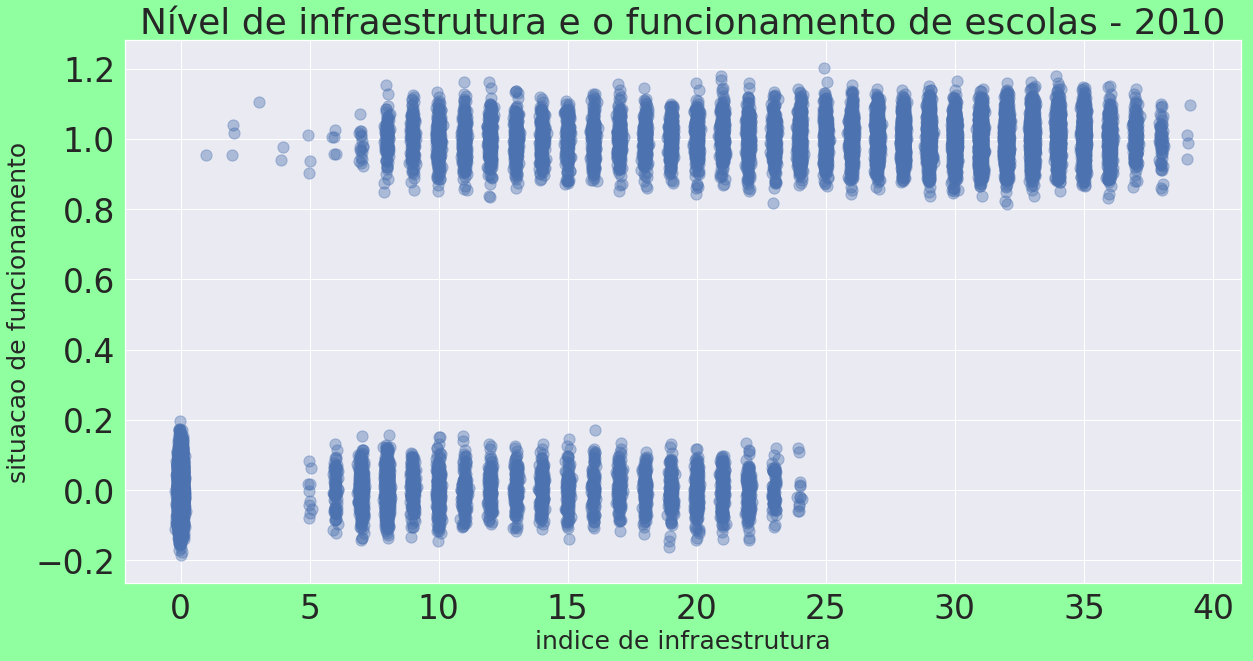

In [23]:
n = df2010.shape[0]

x = df2010['infra']  + np.random.normal(0, 0.05, size=n)
y = df2010['TP_SITUACAO_FUNCIONAMENTO_y'] + np.random.normal(0, 0.05, size=n)

fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
plt.scatter(x, y, s=np.pi*40, alpha=0.4)
plt.title('Nível de infraestrutura e o funcionamento de escolas - 2010')
plt.ylabel('situacao de funcionamento',fontsize=25)
plt.xlabel('indice de infraestrutura',fontsize=25)
plt.show()

In [24]:
#transformando saida em inteirios pois logitico só funciona pra binario
df2010['TP_SITUACAO_FUNCIONAMENTO_y'] =  df2010['TP_SITUACAO_FUNCIONAMENTO_y'].astype('int64')

In [66]:
df2018['TP_SITUACAO_FUNCIONAMENTO'] =  df2018['TP_SITUACAO_FUNCIONAMENTO'].astype('int64')

In [70]:
X = df2010['infra'].to_frame()
Y = df2010['TP_SITUACAO_FUNCIONAMENTO_y']

In [71]:
# loss = log, logistic
# penalty = none, sem regularizar
# fit_intercept = false, colocamos na marra em X já um intercepto
# penalty == none pois não vamos regularizar
# solver indica como o sklearn vai otimizar

X_train = X[:19904]
X_test = X[19904:]
Y_train = Y[:19904]
Y_test = Y[19904:]

model = LogisticRegression(penalty='none', fit_intercept=False, solver='lbfgs')
model = model.fit(X_train, Y_train)

In [72]:
score = model.score(X_test, Y_test)
print(score)

pred = model.predict(X_test)

0.8828976673309108


In [310]:
#tentando usar cross validation

'''
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) 

for train_index, test_index in kf.split(X):
      #print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = X[train_index], X[test_index] 
      y_train, y_test = y[train_index], y[test_index]
'''

## Métricas de Fairness 

In [31]:
#separando os grupos que desejamos comparar
montes_claros = df2010[df2010['CO_MESORREGIAO'] == 3102]
barbacena = df2010[df2010['CO_MESORREGIAO'] == 3107]

In [38]:
X_barbacena = barbacena['infra'].to_frame()
Y_barbacena = barbacena['TP_SITUACAO_FUNCIONAMENTO_y'].to_frame()

X_montes_claros = montes_claros['infra'].to_frame()
Y_montes_claros = montes_claros['TP_SITUACAO_FUNCIONAMENTO_y'].to_frame()

pred_test = model.predict(X_test)
pred_barbacena = model.predict(X_barbacena)
pred_montes_claros = model.predict(X_montes_claros)

In [39]:
barbacena_map = {'Predito': pred_barbacena,
        'Verdadeiro':    Y_barbacena.values.squeeze()
        }
montes_claros_map = {'Predito': pred_montes_claros,
        'Verdadeiro':    Y_montes_claros.values.squeeze()
        }

In [40]:
mc_montes_claros = ConfusionMatrix(montes_claros_map['Verdadeiro'], montes_claros_map['Predito'])
mc_barbacena = ConfusionMatrix(barbacena_map['Verdadeiro'], barbacena_map['Predito'])

### Igualdade de Chances

Predito        0     1
Verdadeiro            
0           3214   999
1              0  4318


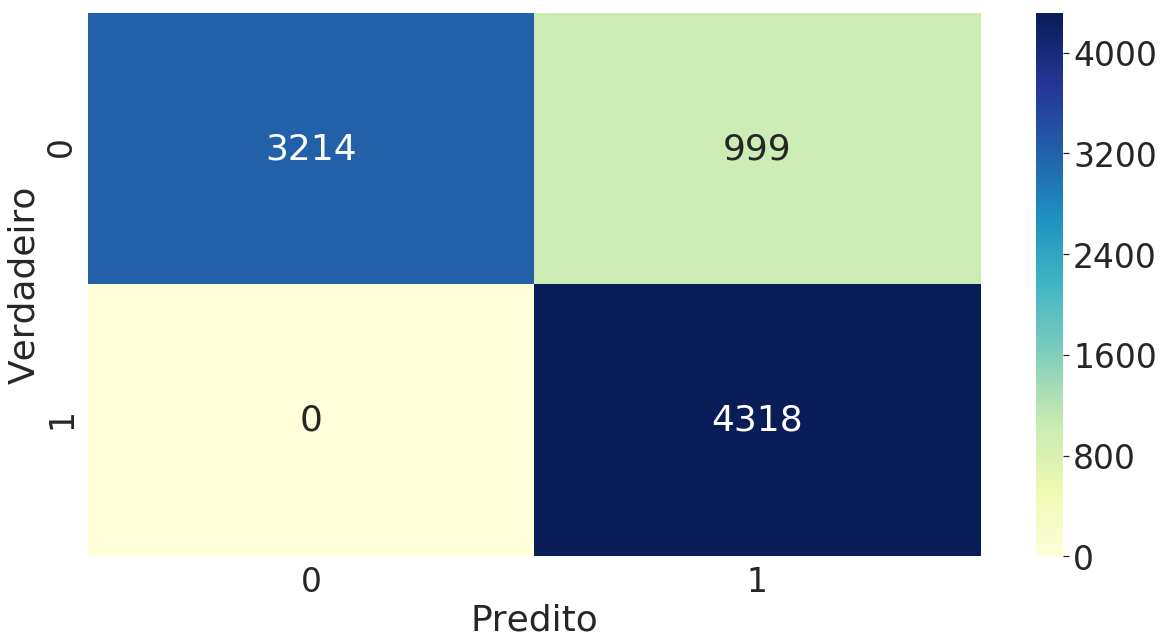

In [73]:
"""data = {'Predito': pred,
        'Verdadeiro':    Y_test
        }

df = pd.DataFrame(data, columns=['Predito','Verdadeiro'])

confusion_matrix = pd.crosstab(df['Verdadeiro'], df['Predito'],
                               rownames=['Verdadeiro'], colnames=['Predito'])

fig = plt.figure(figsize = (20, 10))
sns.set(font_scale=3)
sns.heatmap(confusion_matrix, annot=True)"""

data = {'y_Predicted': pred,
        'y_Actual':    Y_test
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Verdadeiro'], colnames=['Predito'])

fig = plt.figure(figsize = (20, 10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu",fmt='g')

print (confusion_matrix)

In [329]:
"""
Geral:
    TP: 3384
    TN: 6524
    FP: 0
    FN: 861

Barbacena:
    TP: 3552
    TN: 2567
    FP: 0
    FN: 543

Montes Claros:
    TP: 1171
    TN: 2122
    FP: 0
    FN: 589
"""

'\nGeral:\n    TP: 3384\n    TN: 6524\n    FP: 0\n    FN: 861\n\nBarbacena:\n    TP: 3552\n    TN: 2567\n    FP: 0\n    FN: 543\n\nMontes Claros:\n    TP: 1171\n    TN: 2122\n    FP: 0\n    FN: 589\n'

In [49]:


FP_montes_claros = 0
FN_montes_claros = mc_montes_claros.FN / mc_montes_claros.population


FP_barbacena = 0
FN_barbacena = mc_barbacena.FN / mc_barbacena.population

#Confusion_Matrix.print_stats()

#Confusion_Matrix.plot(normalized=True,backend='seaborn')
#plt.show()
print("    Falsos Positivos")
print("Barbacena ----- Montes Claros")
print("      ",FP_barbacena,"---------", FP_montesclaros)
print()
print("           Falsos Negativos")
print("  Barbacena --------------- Montes Claros")
print(FN_barbacena,"-----", FN_montesclaros)

    Falsos Positivos
Barbacena ----- Montes Claros


NameError: name 'FP_montesclaros' is not defined

### Paridade Estatistica

In [42]:
P_barbacena = mc_barbacena.PositiveTest / mc_barbacena.population
N_barbacena = mc_barbacena.NegativeTest / mc_barbacena.population

P_montes_claros = mc_montes_claros.PositiveTest / mc_montes_claros.population
N_montes_claros = mc_montes_claros.NegativeTest / mc_montes_claros.population

print("Positivos Preditos")
print("Barbacena: ", P_barbacena, "x" , P_montes_claros, ": Montes Claros ")
print()
print("Negativos Preditos")
print("Barbacena: ", N_barbacena, "x", N_montes_claros, ": Montes Claros")

#mc_barbacena.print_stats()


Positivos Preditos
Barbacena:  0.6875749785775492 x 0.5890263582571275 : Montes Claros 

Negativos Preditos
Barbacena:  0.3124250214224507 x 0.4109736417428725 : Montes Claros


### Igualdade de Acuracia

In [348]:
print("Acuracia")
print ("Montes Claros: ",metrics.accuracy_score(Y_montes_claros, pred_montes_claros))
print ("Barbacena: ", metrics.accuracy_score(Y_barbacena, pred_barbacena))

Acuracia
Montes Claros:  0.8482740855229264
Barbacena:  0.9184929450615431
